In [11]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import pandas as pd

In [22]:
def calc_price(theta1, theta2, mu1, mu2, cost, wtp):
    """compute each insurer's price (assumes interior solution)"""
    p1 = (2.*theta1*mu1+theta2*mu2)/3. + cost
    p2 = (2.*theta2*mu2+theta1*mu1)/3. + cost
    return p1, p2
  
    
def calc_t(theta1, theta2, mu1, mu2, cost, wtp):
    """compute the proportion of people choosing each insurer
    assumes interior solution"""
    p1, p2 = calc_price(theta1, theta2, mu1, mu2, cost, wtp)
    t_hat = .5 + (p2 - p1)/(2.*cost)
    return t_hat


def calc_profits(theta1,theta2,mu1,mu2,cost, wtp):
    t= calc_t(theta1, theta2, mu1, mu2, cost, wtp)
    p1,p2 = calc_price(theta1, theta2, mu1, mu2, cost, wtp)
    profits1, profits2 = t*(p1-mu1*theta1), (1-t)*(p2-mu2*theta2)
    hosp_profit = t*theta1*mu1 +  (1-t)*theta2*mu2
    return hosp_profit, profits1, profits2

    
def outside_simlt(mu,cost,wtp):
    """outside option in simult case
    assuming listprice high enough"""
    if wtp < 8*cost/3:
        return 3.*wtp**2/(32.*cost)
    else:
        return (wtp-cost)/(2*mu)
    return 

#arbitrary outside option...
def nash_in_nash(theta1, theta2, mu1, mu2, cost, wtp, outside,beta=.5):
    hosp_profit, profits1, profits2 = calc_profits(theta1, theta2, mu1, mu2, cost,  wtp)
    obj = -1*(np.log(max(hosp_profit-outside,1e-4))*(1-beta) + np.log(profits1)*beta)
    return obj


COST = 10
WTP = 25


print(nash_in_nash(COST,COST, 1, 1, COST, WTP, outside_simlt(.5,COST,WTP)))

-1.5151423275303253


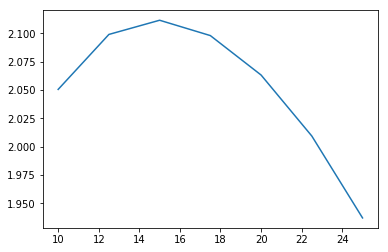

In [23]:
COST = 10
WTP = 25
MU = 1

plt.plot([i for i in np.linspace(COST,WTP,num=7)], 
         [-1*nash_in_nash(i, .75*WTP, MU, MU, COST,WTP, outside_simlt(.5,COST,WTP)) 
                                                          for i in np.linspace(COST,WTP,num=7)])

In [26]:
def bargain_helper(theta1, theta2, mu1, mu2, cost, wtp,beta=.5):
    """solve each firm 1s optimization holding theta 2 fixed"""
    outside = outside_simlt(mu2, cost, wtp)
    result = minimize(nash_in_nash, theta1, args=(theta2, mu1, mu2, cost, wtp, outside,beta),
                      method='Nelder-Mead', options={'disp': False})
    return result.x

COST = 5
WTP  = 25
print(bargain_helper(20,20, 1, 1, COST,WTP))

[15.89758301]


In [28]:
def simult_bargain(theta1, theta2, mu1, mu2, cost, listprice,betas=[.5,.5]):
    """solve the bargaining problems seperately and iterate for a solution"""       
    
    #loop variables
    diff =  theta1

    maxiter = 10
    while maxiter >=0 and diff > 10e-7:
        #seems as though there is a contraction mapping here, need to think more about why
        theta1 = bargain_helper(theta1, theta2, mu1, mu2, cost, listprice,betas[0])
        theta2 = bargain_helper(theta2, theta1, mu2, mu1, cost,  listprice,betas[1])
        
        #update loop variables
        diff = np.abs(np.max(theta1 - theta2))
        maxiter = maxiter-1
        
    return theta1, theta2

COST = 5
WTP  = 25
print(simult_bargain(11.25,11.25,1,1,COST,WTP))

(array([13.74998685]), array([13.75003069]))


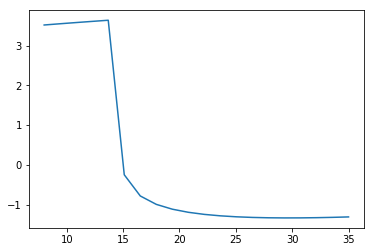

In [31]:
def outside_seq(theta1,mu1,cost,wtp):
    """assume that we amp up list price high enough
    for a corner solution"""
    return mu1*theta1


def bargain_helper_seq(theta1, mu1, mu2, cost, wtp,beta=.5):
    """ solve firm 1s optimization holding theta 2 fixed """
    outside = outside_simlt(mu2,cost,wtp)
    result = minimize( nash_in_nash, 10., args=(theta1, mu2, mu1, cost, wtp, outside,beta),
                      method='Nelder-Mead', options={'disp': False} )
    return result.x


def seq_obj(theta1, mu1, mu2, cost, wtp,betas=[.5,.5]):
    """ theta1 is a guess for the first stage """
    
    theta2 = bargain_helper_seq(theta1, mu2, mu1, cost, wtp, betas[1])
    outside1 = outside_seq(theta2, mu2, cost, wtp)
    
    return nash_in_nash(theta1, theta2, mu1, mu2, cost, wtp, outside1,betas[0])


COST = 5
WTP = 25
plt.plot([i for i in np.linspace(COST+3,WTP +10,num=20)],  
         [seq_obj(i, 1, 1, 13.5 , WTP) for i in np.linspace(COST+3,WTP +10,num=20)])


In [33]:
def seq_bargain(theta1, mu1, mu2, cost, wtp,betas=[.5,.5]):
    """solve the bargaining problems seperately,
    then solve for the solution"""   
    #only compute no deal 1x for initial
    result = minimize(seq_obj, theta1, args=(mu1, mu2, cost, wtp,betas),
                      method='Nelder-Mead', options={'disp': False})
    
    theta1 = result.x
    theta2 = bargain_helper(theta1, theta1, mu2, mu1, cost, wtp,beta=betas[1])
    return theta1, theta2

print(seq_bargain(17,1,1,5,25))

(array([19.37500916]), array([15.62500357]))


In [36]:
def make_table(arg, steps, params,betas=[.5,.5]):
    """the argument is 
    args = 0 - mu1, 1- mu2, 2 -cost, 3 - wtp
    steps = min_arg, max_arg, no_step """
    
    min_arg, max_arg, no_step = steps
    
    cols = ['eq_type','listprice','distance_cost','mc1','mc2','profit1','profit2','hosp_profit','share1','share2']
    
    indep_var = np.linspace(min_arg, max_arg, no_step)
    
    for eq_type in ['Simultaneous', 'Sequential']:
        result1 = []
        result2 = []
        for var in indep_var:
        
            param_copy = list(params)
            param_copy[arg] = var
            mu1,mu2,cost,wtp = param_copy
            
            mc1,mc2 = 25,25
            
            if eq_type == 'Simultaneous':
                mc1,mc2 = simult_bargain(mc1, mc2, mu1, mu2, cost, wtp,betas=betas)
            else:
                mc1,mc2 = seq_bargain(mc1, mu1, mu2, cost, wtp,betas=betas)
            
            s1 = calc_t(mc1,mc2,mu1, mu2, cost,wtp)
            s2 = calc_t(mc2,mc1,mu2, mu1, cost,wtp)
            p1,p2 = calc_price(mc1,mc2,mu1, mu2, cost,wtp)
            pi1,pi2 = s1*(p1-mc1),  s2*(p2-mc2)
            pi_h = s1*mc1 + s2*mc2
            cons1 = wtp - s1*cost - p1
            cons2 = wtp - s2*cost - p2
            
            result1.append( (cost, wtp, mc1, s1, p1, pi1,  pi_h, cons1) ) 
            result2.append( (cost, wtp, mc2, s2, p2, pi2,  pi_h, cons2) ) 
        print('\n',eq_type, '\n')
        
        for line in result1:
            print("%.3f & %.3f  & %.3f  & %.3f  & %.3f  & %.3f  & %.3f & %.3f \\\\"%line)
            
        print('\n')
        
        for line in result2:
            print("%.3f & %.3f  & %.3f  & %.3f  & %.3f  & %.3f  & %.3f & %.3f \\\\"%line)
            
    

make_table(3, (25,29,5), (1,1,5,25))


 Simultaneous 

5.000 & 25.000  & 13.750  & 0.500  & 18.750  & 2.500  & 13.750 & 3.750 \\
5.000 & 26.000  & 14.250  & 0.500  & 19.250  & 2.500  & 14.250 & 4.250 \\
5.000 & 27.000  & 14.750  & 0.500  & 19.750  & 2.500  & 14.750 & 4.750 \\
5.000 & 28.000  & 15.250  & 0.500  & 20.250  & 2.500  & 15.250 & 5.250 \\
5.000 & 29.000  & 15.750  & 0.500  & 20.750  & 2.500  & 15.750 & 5.750 \\


5.000 & 25.000  & 13.750  & 0.500  & 18.750  & 2.500  & 13.750 & 3.750 \\
5.000 & 26.000  & 14.250  & 0.500  & 19.250  & 2.500  & 14.250 & 4.250 \\
5.000 & 27.000  & 14.750  & 0.500  & 19.750  & 2.500  & 14.750 & 4.750 \\
5.000 & 28.000  & 15.250  & 0.500  & 20.250  & 2.500  & 15.250 & 5.250 \\
5.000 & 29.000  & 15.750  & 0.500  & 20.750  & 2.500  & 15.750 & 5.750 \\

 Sequential 

5.000 & 25.000  & 19.375  & 0.375  & 23.125  & 1.406  & 17.031 & 0.000 \\
5.000 & 26.000  & 26.250  & 0.267  & 28.919  & 0.712  & 21.124 & -4.254 \\
5.000 & 27.000  & 25.000  & 0.294  & 27.943  & 0.866  & 20.646 & -2.415 \\
5.

In [37]:
make_table(2, (5,9,5), (1,1,5,25))


 Simultaneous 

5.000 & 25.000  & 13.750  & 0.500  & 18.750  & 2.500  & 13.750 & 3.750 \\
6.000 & 25.000  & 14.000  & 0.500  & 20.000  & 3.000  & 14.000 & 2.000 \\
7.000 & 25.000  & 14.250  & 0.500  & 21.250  & 3.500  & 14.250 & 0.250 \\
8.000 & 25.000  & 14.500  & 0.500  & 22.500  & 4.000  & 14.500 & -1.500 \\
9.000 & 25.000  & 14.750  & 0.500  & 23.750  & 4.500  & 14.750 & -3.250 \\


5.000 & 25.000  & 13.750  & 0.500  & 18.750  & 2.500  & 13.750 & 3.750 \\
6.000 & 25.000  & 14.000  & 0.500  & 20.000  & 3.000  & 14.000 & 2.000 \\
7.000 & 25.000  & 14.250  & 0.500  & 21.250  & 3.500  & 14.250 & 0.250 \\
8.000 & 25.000  & 14.500  & 0.500  & 22.500  & 4.000  & 14.500 & -1.500 \\
9.000 & 25.000  & 14.750  & 0.500  & 23.750  & 4.500  & 14.750 & -3.250 \\

 Sequential 

5.000 & 25.000  & 19.375  & 0.375  & 23.125  & 1.406  & 17.031 & 0.000 \\
6.000 & 25.000  & 20.750  & 0.375  & 25.250  & 1.688  & 17.937 & -2.500 \\
7.000 & 25.000  & 22.125  & 0.375  & 27.375  & 1.969  & 18.844 & -5.000 \

In [38]:
make_table(2, (5,6,1), (1,1,5,25),betas=[.482,.34])


 Simultaneous 

5.000 & 25.000  & 14.626  & 0.549  & 20.114  & 3.012  & 15.287 & 2.142 \\


5.000 & 25.000  & 16.090  & 0.451  & 20.602  & 2.036  & 15.287 & 2.142 \\

 Sequential 

5.000 & 25.000  & 27.500  & 0.357  & 31.067  & 1.272  & 24.734 & -7.850 \\


5.000 & 25.000  & 23.201  & 0.643  & 29.634  & 4.138  & 24.734 & -7.850 \\


In [36]:
#print some numerical derivatives

for j in np.linspace(25,27, 3):
    for i in np.linspace(19,22,4):
        WTP = j
        COST = 5
        diff = .1
        theta2 = bargain_helper_seq(i, 1,1, COST, WTP)
        theta2_dist = bargain_helper_seq(i + diff , 1,1, COST, WTP)
        deriv = (theta2_dist-theta2)/diff
    
        print('%.3f & %.3f  & %.3f & %.3f \\\\'%(WTP,COST,i,deriv))


25.000 & 5.000  & 19.000 & 0.421 \\
25.000 & 5.000  & 20.000 & 0.445 \\
25.000 & 5.000  & 21.000 & 0.466 \\
25.000 & 5.000  & 22.000 & 0.485 \\
26.000 & 5.000  & 19.000 & 0.407 \\
26.000 & 5.000  & 20.000 & 0.433 \\
26.000 & 5.000  & 21.000 & 0.456 \\
26.000 & 5.000  & 22.000 & 0.476 \\
27.000 & 5.000  & 19.000 & 0.392 \\
27.000 & 5.000  & 20.000 & 0.421 \\
27.000 & 5.000  & 21.000 & 0.445 \\
27.000 & 5.000  & 22.000 & 0.466 \\
